<a href="https://colab.research.google.com/github/saurabhbarge/CE888-7-SP/blob/main/TweetEval_Assignment2/Irony.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing all the Libraries**

In [50]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import re
import string
from wordcloud import WordCloud
from matplotlib import pyplot as plt 
import tensorflow as tf
%matplotlib inline
import seaborn as sns

In [2]:
!pip install transformers

     |████████████████████████████████| 2.1MB 19.2MB/s 
     |████████████████████████████████| 901kB 35.5MB/s 
     |████████████████████████████████| 3.3MB 46.0MB/s 


In [3]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
stop_words = list(set(stopwords.words('english'))) # list of stop words

In [6]:
stemmer = PorterStemmer() # creating stemmer object

In [7]:
lemmatizer = WordNetLemmatizer() # creating lemmatizer object

**Pre-processing Function includes the following:**
**-removes punctuations**
**,removes digits**
**,removes word 'user' which is frequently used in the datasets**
**,removes stopwords**
**,performed stemming**
**,performed lemmatization**

In [8]:
def pre_processing(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub('@user','',text)
    text = ' '.join([x for x in word_tokenize(text) if x not in stop_words])
    text = ' '.join([stemmer.stem(x) for x in word_tokenize(text)])
    # text = ' '.join([lemmatizer.lemmatize(x) for x in word_tokenize(text)])
    return text

**Function for removing emojis**

In [9]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [10]:
def dataset_create(filepath_text,filepath_labels):
    with open(filepath_text) as data:
        read_text = data.read()

    with open(filepath_labels) as data:
        read_labels = data.read()   
    
    read_text = read_text.split("\n")
    read_labels = read_labels.split("\n")
    read_text = [x.lower() for x in read_text]  
    
    df = pd.DataFrame({'Text':read_text,'Labels':read_labels})
    return df

In [11]:
train_irony = dataset_create("/content/drive/MyDrive/irony/train_text.txt","/content/drive/MyDrive/irony/train_labels.txt")

In [12]:
val_irony = dataset_create("/content/drive/MyDrive/irony/val_text.txt","/content/drive/MyDrive/irony/val_labels.txt")

In [13]:
test_irony = dataset_create("/content/drive/MyDrive/irony/test_text.txt","/content/drive/MyDrive/irony/test_labels.txt")

In [14]:
# cleaning the train data
train_irony['Text'] = train_irony['Text'].apply(lambda x: pre_processing(x))
train_irony['Text'] = train_irony['Text'].apply(lambda x: remove_emoji(x))

#cleaning the validation data
val_irony['Text'] = val_irony['Text'].apply(lambda x: pre_processing(x))
val_irony['Text'] = val_irony['Text'].apply(lambda x: remove_emoji(x))

#cleaning the test data
test_irony['Text'] = test_irony['Text'].apply(lambda x: pre_processing(x))
test_irony['Text'] = test_irony['Text'].apply(lambda x: remove_emoji(x))

**Mapping Labels**

In [15]:
# df_irony['Irony_labels'] = df_irony['Irony_labels'].map({'0': 'non_irony', '1': 'irony'})

**Checking the count of labels**

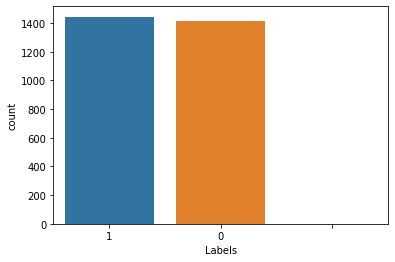

In [16]:
sns.countplot(x="Labels", data=train_irony) 

**Checking for Missing Values**

In [17]:
train_irony.isna().sum()

Text      0
Labels    0
dtype: int64

**WORD CLOUD**

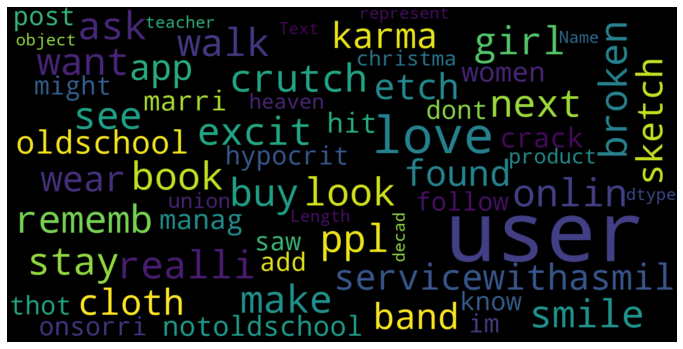

In [18]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(str(train_irony['Text']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Using CountVectorizer and TF-IDF Vectorizer for translating text data into numeric form acceptable by the model**

In [19]:
cv = CountVectorizer(stop_words='english',max_features=10000)
cv_train_features = cv.fit_transform(train_irony['Text'])

In [20]:
tf1 = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),sublinear_tf=True)
tf_train_features = tf1.fit_transform(train_irony['Text'])

In [22]:
cv = CountVectorizer(stop_words='english',max_features=10000)
cv_test_features = cv.fit_transform(test_irony['Text'])

tf1 = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),sublinear_tf=True)
tf_test_features = tf1.fit_transform(test_irony['Text'])

**MODELLING**

**SVM**

In [23]:
from sklearn import svm

In [24]:
clf = svm.SVC()

In [25]:
param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']} 

In [26]:
svm_grid = GridSearchCV(svm.SVC(), param_grid, refit = True) # hyperparameter tuning using gridsearchcv

In [27]:
X_train = tf1.transform(train_irony["Text"])
y_train = train_irony["Labels"]

X_test = tf1.transform(test_irony["Text"])
y_test = test_irony["Labels"]

In [28]:
svm_grid.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [29]:
print(svm_grid.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}


In [30]:
clf1 = svm.SVC(C=10,gamma=0.1,kernel='sigmoid')

In [31]:
clf1.fit(X_train,y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [32]:
preds = clf1.predict(X_test)

In [68]:
print("F1-score:",f1_score(preds, y_test, average='macro'))
print("Accuracy:",accuracy_score(preds,y_test))

F1-score: 0.5239554044100913
Accuracy: 0.6203821656050955


**FASTTEXT**

In [34]:
!pip install fasttext
import fasttext

     |████████████████████████████████| 71kB 3.9MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3092059 sha256=21030bf1700c1ad1a8ece629d70afe67d466f89e891d104f8d42911162e98373
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [35]:
with open('fasttext_irony_inputs.txt', 'w') as f:  #Converting data to a format accepted by fasttext and storing it in a text file
    for each_text, each_label in zip(train_irony['Text'], train_irony['Labels']):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [54]:
fcl = fasttext.train_supervised('fasttext_irony_inputs.txt', lr=0.01, wordNgrams=2, epoch=100)

In [55]:
predictions1 = fcl.predict(test_irony['Text'].to_list())
print(predictions1[0])

[['__label__0'], ['__label__0'], ['__label__0'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__0'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__0'], ['__label__1'], ['__label__0'], ['__label__0'], ['__label__0'], ['__label__0'], ['__label__1'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__0'], ['__label__1'], ['__label__0'], ['__label__0'], ['__label__0'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__0'], ['__label__0'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__1'], ['__label__0'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__1'], ['__label__1'], ['__lab

In [56]:
def cleanpred_(text): # cleaning the predictions obtained by Fasttext 
  return text[0].replace("__label__","")

In [57]:
fast_preds = map(cleanpred_,predictions1[0])
fast_preds = list(fast_preds)  # final predictions of fasttext model after cleaning
print(fast_preds) 

['0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '1', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0', '1', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '1', '1', '1', '0', '1', '0', '0', '1', '1', '1', '1', '1', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '0', '1', '1', '1', '0',

In [69]:
print("F1-score:",f1_score(y_test,fast_preds,average='macro'))
print("Accuracy:",accuracy_score(y_test,fast_preds))

F1-score: 0.4314998437834016
Accuracy: 0.6509554140127388


**ROBERTA-BASE**

In [41]:
task='irony'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [42]:
labels = ['0','1']  

In [43]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [44]:
sents = list(test_irony['Text'][:]) # storing all the texts in a list
print(sents)

['user u helpmor conserv need tsu get paid post stuff like thisyou go', 'walk starbuck ask tall blond hahahaha ironi', 'gon na win', 'user exactli sort person weirdo', 'much sarcasm work mate bore dead mate full shit absolut sleep mate cant handl sarcasm', 'corni joke absolut favorit', 'peopl complain backround pic feel like hey dont blame albert e might spoken word sarcasm life', 'user user darn sock joke need fix', 'christian expect fifa sleep bed tonight he wrong ', 'peopl tell peopl anxieti stop worri favorit kind peopl educateyourself', 'import thing ive learn school', 'orionlaunch underway yeah orion', 'love context larg ensembl friday der favourit sarcasm getthefuckout', 'oh boy user hous warm dj booth user', 'liar ive never deni murder chicago user user user user user', 'alway classi never trashi littl sassi', 'believ say someth provid proof fact wrong user user', 'user long go mainstream media pitch surgeri follow use prototyp demonstr real situationphil', 'user jami grace tou

In [45]:
test_irony.shape

(785, 2)

In [46]:
def get_preds(sentence): # custom prediction function to extract the predicted labels
    text = sentence
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)  
    ranking = np.argsort(scores)
    ranking = ranking[::-1]

    dict1 = {}
    preds = []
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        # print(f"{i+1}) {l} {np.round(float(s), 4)}")
        dict1[l] = s
        pred = max(dict1, key=dict1.get)
        preds.append(pred)

    prediction = list(set(preds))

    return prediction    

In [47]:
result = map(lambda x: get_preds(x), sents)

In [48]:
roberta_preds = list(result)
roberta_preds = [item for sublist in roberta_preds for item in sublist] #final list of predictions

print(roberta_preds)

['1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0',

In [65]:
print("F1-score:",f1_score(y_test,roberta_preds,average='macro'))
print("Accuracy:",accuracy_score(roberta_preds,y_test))

F1-score: 0.3788199968007941
Accuracy: 0.6280254777070063


**RANDOM FOREST**

In [61]:
rf = RandomForestClassifier(n_estimators=500)

In [62]:
rf.fit(X_train,y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
rf_preds = rf.predict(X_test) 

In [66]:
print("F1-score:",f1_score(y_test,rf_preds,average='macro'))
print("Accuracy:",accuracy_score(rf_preds,y_test))

F1-score: 0.43800320949735133
Accuracy: 0.6764331210191082
